## Imports

In [1]:
import datetime
import os

In [2]:
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.metrics import *

In [3]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import *
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


## Config

In [4]:
RANDOM_SEED = 42

In [5]:
data_folder = os.path.abspath(os.path.join(os.curdir, os.pardir, 'data')) + os.path.sep
aux_data_folder = os.path.join(data_folder, 'aux') + os.path.sep
preproc_data_folder = os.path.join(data_folder, 'preproc') + os.path.sep
features_data_folder = os.path.join(data_folder, 'features') + os.path.sep
submissions_data_folder = os.path.join(data_folder, 'submissions') + os.path.sep

## Read Data

In [6]:
embedding_matrix = load(aux_data_folder + 'embedding_weights_fasttext_filtered_no_stopwords.pickle')

In [7]:
X_train_q1 = load(features_data_folder + 'X_train_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_train_q2 = load(features_data_folder + 'X_train_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [8]:
X = np.stack((X_train_q1, X_train_q2), axis=1)

In [9]:
y = load(features_data_folder + 'y_train.pickle')

In [10]:
EMBEDDING_DIM = embedding_matrix.shape[-1]
VOCAB_LENGTH = embedding_matrix.shape[0] - 1
MAX_SEQUENCE_LENGTH = X.shape[-1]

In [11]:
print(EMBEDDING_DIM, VOCAB_LENGTH, MAX_SEQUENCE_LENGTH)

300 101441 30


In [12]:
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.15,
    random_state=RANDOM_SEED,
    stratify=y
)

In [13]:
print('X train:', X_train.shape)
print('y train:', y_train.shape)
print('X val:  ', X_val.shape)
print('y val:  ', y_val.shape)

X train: (343646, 2, 30)
y train: (343646,)
X val:   (60644, 2, 30)
y val:   (60644,)


In [14]:
X_train_q1 = X_train[:, 0]
X_train_q2 = X_train[:, 1]
X_val_q1 = X_val[:, 0]
X_val_q2 = X_val[:, 1]

In [15]:
print('X train Q1:', X_train_q1.shape)
print('y train Q1:', X_train_q2.shape)
print('X val Q1:  ', X_val_q1.shape)
print('y val Q1:  ', X_val_q2.shape)

X train Q1: (343646, 30)
y train Q1: (343646, 30)
X val Q1:   (60644, 30)
y val Q1:   (60644, 30)


## Train Model

In [16]:
num_conv_filter = 64
conv_filter_size = 5
pool_length = 4

In [17]:
model = Sequential()

In [18]:
model1 = Sequential()
model1.add(Embedding(VOCAB_LENGTH + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model1.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
model1.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM,)))

In [19]:
model2 = Sequential()
model2.add(Embedding(VOCAB_LENGTH + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))

model2.add(TimeDistributed(Dense(EMBEDDING_DIM, activation='relu')))
model2.add(Lambda(lambda x: K.sum(x, axis=1), output_shape=(EMBEDDING_DIM,)))

In [20]:
model3 = Sequential()
model3.add(Embedding(VOCAB_LENGTH + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model3.add(Convolution1D(nb_filter=num_conv_filter,
                         filter_length=conv_filter_size,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))
model3.add(Dropout(0.2))

model3.add(Convolution1D(nb_filter=num_conv_filter,
                         filter_length=conv_filter_size,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))

model3.add(GlobalMaxPooling1D())
model3.add(Dropout(0.2))

model3.add(Dense(EMBEDDING_DIM))
model3.add(Dropout(0.2))
model3.add(BatchNormalization())

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`


In [21]:
model4 = Sequential()
model4.add(Embedding(VOCAB_LENGTH + 1,
                     EMBEDDING_DIM,
                     weights=[embedding_matrix],
                     input_length=MAX_SEQUENCE_LENGTH,
                     trainable=False))
model4.add(Convolution1D(nb_filter=num_conv_filter,
                         filter_length=conv_filter_size,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))
model4.add(Dropout(0.2))

model4.add(Convolution1D(nb_filter=num_conv_filter,
                         filter_length=conv_filter_size,
                         border_mode='valid',
                         activation='relu',
                         subsample_length=1))

model4.add(GlobalMaxPooling1D())
model4.add(Dropout(0.2))

model4.add(Dense(EMBEDDING_DIM))
model4.add(Dropout(0.2))
model4.add(BatchNormalization())

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`
  # This is added back by InteractiveShellApp.init_path()
/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=64, kernel_size=5, strides=1, padding="valid")`


In [22]:
model5 = Sequential()
model5.add(Embedding(
    VOCAB_LENGTH + 1,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    dropout=0.2
))
model5.add(LSTM(EMBEDDING_DIM, dropout_W=0.2, dropout_U=0.2))

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, dropout=0.2, recurrent_dropout=0.2)`
  


In [23]:
model6 = Sequential()
model6.add(Embedding(
    VOCAB_LENGTH + 1,
    EMBEDDING_DIM,
    input_length=MAX_SEQUENCE_LENGTH,
    dropout=0.2
))
model6.add(LSTM(
    EMBEDDING_DIM,
    dropout_W=0.2,dropout_U=0.2
))

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: UserWarning: The `dropout` argument is no longer support in `Embedding`. You can apply a `keras.layers.SpatialDropout1D` layer right after the `Embedding` layer to get the same behavior.
  
/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:10: UserWarning: Update your `LSTM` call to the Keras 2 API: `LSTM(300, dropout=0.2, recurrent_dropout=0.2)`
  # Remove the CWD from sys.path while we load stuff.


In [24]:
model = Sequential()
model.add(Merge([model1, model2, model3, model4, model5, model6], mode='concat'))
model.add(BatchNormalization())

model.add(Dense(EMBEDDING_DIM))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(EMBEDDING_DIM))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(EMBEDDING_DIM))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(EMBEDDING_DIM))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(EMBEDDING_DIM))
model.add(PReLU())
model.add(Dropout(0.2))
model.add(BatchNormalization())

model.add(Dense(1))
model.add(Activation('sigmoid'))

/home/yuriyguts/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: The `Merge` layer is deprecated and will be removed after 08/2017. Use instead layers from `keras.layers.merge`, e.g. `add`, `concatenate`, etc.
  


In [25]:
model.compile(
    loss='binary_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy']
)

In [26]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
merge_1 (Merge)              (None, 1800)              0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1800)              7200      
_________________________________________________________________
dense_5 (Dense)              (None, 300)               540300    
_________________________________________________________________
p_re_lu_1 (PReLU)            (None, 300)               300       
_________________________________________________________________
dropout_7 (Dropout)          (None, 300)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 300)               1200      
_________________________________________________________________
dense_6 (Dense)              (None, 300)               90300     
__________

In [27]:
def get_class_weights(y, smooth_factor=0):
    """
    Returns the weights for each class based on the frequencies of the samples
    :param smooth_factor: factor that smooths extremely uneven weights
    :param y: list of true labels (the labels must be hashable)
    :return: dictionary with the weight for each class
    """
    from collections import Counter    
    counter = Counter(y)

    if smooth_factor > 0:
        p = max(counter.values()) * smooth_factor
        for k in counter.keys():
            counter[k] += p

    majority = max(counter.values())

    return {cls: float(majority / count) for cls, count in counter.items()}

In [28]:
callbacks = [
    EarlyStopping(monitor='val_loss', min_delta=0.01, patience=3, verbose=1, mode='auto')
]

In [29]:
history = model.fit(
    [X_train_q1, X_train_q2, X_train_q1, X_train_q2, X_train_q1, X_train_q2], y_train,
    batch_size=384,
    epochs=50,
    validation_data=([X_val_q1, X_val_q2, X_val_q1, X_val_q2, X_val_q1, X_val_q2], y_val),
    class_weight=get_class_weights(y_train),
    callbacks=callbacks,
)

Train on 343646 samples, validate on 60644 samples
Epoch 1/50
343646/343646 [==============================] - 145s - loss: 0.6877 - acc: 0.7188 - val_loss: 0.4833 - val_acc: 0.7675
Epoch 2/50
343646/343646 [==============================] - 142s - loss: 0.5389 - acc: 0.7952 - val_loss: 0.4666 - val_acc: 0.7761
Epoch 3/50
343646/343646 [==============================] - 143s - loss: 0.4360 - acc: 0.8397 - val_loss: 0.4654 - val_acc: 0.7893
Epoch 4/50
343646/343646 [==============================] - 144s - loss: 0.3551 - acc: 0.8716 - val_loss: 0.5077 - val_acc: 0.7902
Epoch 5/50
343646/343646 [==============================] - 148s - loss: 0.2917 - acc: 0.8963 - val_loss: 0.5382 - val_acc: 0.7902
Epoch 6/50
343646/343646 [==============================] - 149s - loss: 0.2475 - acc: 0.9134 - val_loss: 0.5818 - val_acc: 0.7935
Epoch 00005: early stopping


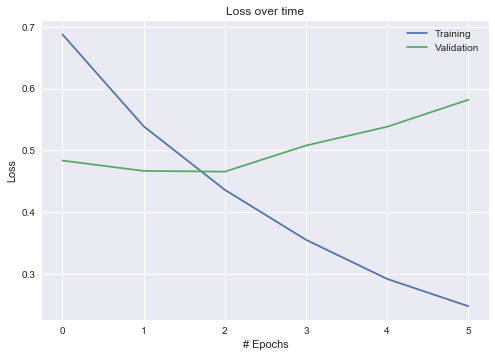

In [30]:
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
 
plt.xlabel("# Epochs")
plt.ylabel("Loss")
plt.legend(["Training", "Validation"])
plt.title("Loss over time")
 
plt.show()

## Evaluate Model

In [31]:
y_pred_train = model.predict_classes([X_train_q1, X_train_q2])[:, -1]
y_pred_proba_train = model.predict_proba([X_train_q1, X_train_q2])[:, -1]

ValueError: Error when checking : the list of Numpy arrays that you are passing to your model is not the size the model expected. Expected to see 6 arrays but instead got the following list of 2 arrays: [array([[   0,    0,    0, ...,  163,  244,   73],
       [   0,    0,    0, ..., 1064,  304, 5171],
       [   0,    0,    0, ...,   12, 1671,  556],
       ..., 
       [   0,    0,    0, ...,   30,...

In [ ]:
y_pred_val = model.predict_classes([X_val_q1, X_val_q2])[:, -1]
y_pred_proba_val = model.predict_proba([X_val_q1, X_val_q2])[:, -1]

In [ ]:
continuous_metrics = [log_loss, roc_auc_score]

In [ ]:
binary_metrics = [accuracy_score, precision_score, recall_score]

### Train

In [ ]:
for metric in continuous_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_train, y_pred_proba_train)))
for metric in binary_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_train, y_pred_train)))

### Validation

In [ ]:
for metric in continuous_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_val, y_pred_proba_val)))
for metric in binary_metrics:
    print('{:20s}: {:10.5f}'.format(metric.__name__, metric(y_val, y_pred_val)))

In [ ]:
raise ValueError('Stopping before the test set')

### Test

In [ ]:
X_test_q1 = load(features_data_folder + 'X_test_nn_fasttext_q1_filtered_no_stopwords.pickle')
X_test_q2 = load(features_data_folder + 'X_test_nn_fasttext_q2_filtered_no_stopwords.pickle')

In [ ]:
y_test = model.predict_proba([X_test_q1, X_test_q2])[:, -1]

In [ ]:
submission_id = datetime.datetime.now().strftime('%Y-%m-%d-%H%M')

In [ ]:
df_submission = pd.DataFrame({
    'test_id': range(len(y_test)),
    'is_duplicate': y_test
})

In [ ]:
df_submission = df_submission[['test_id', 'is_duplicate']]

In [ ]:
df_submission.head(10)

In [ ]:
df_submission.to_csv(
    submissions_data_folder + submission_id + '-submission-draft.csv',
    header=True,
    float_format='%.8f',
    index=None,
)